In [54]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from finta import TA
from keras.models import Sequential
from keras.layers import Dense, Activation

In [2]:
ticker = "BTC-USD"

btc_df = yf.download(ticker, period='2y',  index = "Date", interval = "1h")

btc_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2020-12-01 07:00:00,19326.232422,19487.949219,19317.486328,19487.949219,19487.949219,0
2020-12-01 08:00:00,19486.212891,19543.583984,19457.710938,19476.601562,19476.601562,0
2020-12-01 09:00:00,19475.105469,19545.423828,19433.148438,19544.560547,19544.560547,0
2020-12-01 10:00:00,19547.369141,19780.857422,19547.369141,19741.984375,19741.984375,1530675200
2020-12-01 11:00:00,19739.925781,19845.974609,19308.431641,19440.416016,19440.416016,1673453568


### Add hourly returns column

In [3]:
# Calculate the hourly returns using the closing prices and the pct_change function
btc_df["actual_returns"] = btc_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
btc_df = btc_df.dropna()

# Review the DataFrame
display(btc_df.head())
display(btc_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns
2020-12-01 08:00:00,19486.212891,19543.583984,19457.710938,19476.601562,19476.601562,0,-0.000582
2020-12-01 09:00:00,19475.105469,19545.423828,19433.148438,19544.560547,19544.560547,0,0.003489
2020-12-01 10:00:00,19547.369141,19780.857422,19547.369141,19741.984375,19741.984375,1530675200,0.010101
2020-12-01 11:00:00,19739.925781,19845.974609,19308.431641,19440.416016,19440.416016,1673453568,-0.015275
2020-12-01 12:00:00,19428.390625,19433.207031,18710.615234,18763.216797,18763.216797,2578632704,-0.034835


,Open,High,Low,Close,Adj Close,Volume,actual_returns
2022-12-01 04:00:00,17151.521484,17162.394531,17139.517578,17139.517578,17139.517578,138606592,-0.000765
2022-12-01 05:00:00,17138.978516,17147.177734,17091.931641,17107.232422,17107.232422,206776320,-0.001884
2022-12-01 06:00:00,17108.363281,17122.722656,17096.267578,17119.708984,17119.708984,93251584,0.000729
2022-12-01 07:00:00,17119.576172,17120.011719,17103.171875,17116.500000,17116.500000,63604736,-0.000187
2022-12-01 07:50:00,17116.351562,17116.351562,17116.351562,17116.351562,17116.351562,0,-0.000009


### Generating the Features and Target Sets

In [71]:
# Generate 3EMA with windows 5, 8, 13

short_window = 5
middle_window = 8
long_window = 13

# Create a short window EMA
btc_df["EMA5"] = btc_df["Close"].ewm(span=short_window).mean()

# Create a middle window EMA
btc_df["EMA8"] = btc_df["Close"].ewm(span=middle_window).mean()

# Create a short window EMA
btc_df["EMA13"] = btc_df["Close"].ewm(span=long_window).mean()

In [5]:
# Generate RSI
btc_rsi = TA.RSI(btc_df)  

# Join RSI with the original dataframe.
btc_df = pd.concat([btc_df, btc_rsi], axis = 1)

In [6]:
# Generate Bolinger Bands
btc_bbands_df = TA.BBANDS(btc_df)

# Concatenate the Bollinger Bands to the DataFrame
btc_df = pd.concat([btc_df,btc_bbands_df], axis=1)

In [7]:
# Drop nulls & review new df
btc_df = btc_df.dropna()

btc_df.head()

,Open,High,Low,Close,Adj Close,Volume,actual_returns,EMA5,EMA8,EMA13,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2020-12-02 03:00:00,18709.949219,18777.013672,18547.046875,18573.548828,18573.548828,0,-0.007398,18747.440866,18812.587417,18880.366310,33.172811,19680.885777,19054.001074,18427.116371
2020-12-02 04:00:00,18580.386719,18688.109375,18347.718750,18506.279297,18506.279297,270094336,-0.003622,18667.037557,18744.169697,18824.740602,31.747935,19644.729211,19005.484961,18366.240711
2020-12-02 05:00:00,18514.736328,18662.427734,18498.080078,18641.208984,18641.208984,1116958720,0.007291,18658.426882,18721.198336,18797.608411,37.542895,19565.957549,18960.317383,18354.677217
2020-12-02 06:00:00,18648.583984,18890.400391,18648.583984,18890.400391,18890.400391,860889088,0.013368,18735.758275,18758.915263,18811.258278,46.566117,19398.948365,18917.738184,18436.528002
2020-12-02 07:00:00,18892.275391,19072.173828,18871.671875,19072.173828,19072.173828,0,0.009623,18847.903455,18828.695875,18849.477197,52.012294,19320.803057,18899.326074,18477.849092


### Create target set

In [8]:
btc_signals_df = pd.DataFrame()
btc_signals_df["Close"] = btc_df["Close"]

In [9]:
# Create a trading algorithm using Bollinger Bands
# Set the Signal column
btc_signals_df["Signal"] = 0.0

# Generate the trading signals 1 (entry) or -1 (exit) for a long position trading algorithm
# where 1 is when the Close price is less than the EMA 200 and under 25 for RSI.
# where -1 is when the Close price is greater than 80 RSI.
for index, row in btc_df.iterrows():
    if row["14 period RSI"] <= 25:
        btc_signals_df.loc[index, "Signal"] = 1.0
    if row["14 period RSI"] >= 80:
        btc_signals_df.loc[index,"Signal"] = -1.0

btc_signals_df["Signal"] = btc_signals_df["Signal"]
btc_signals_df["Entry/Exit"] = btc_signals_df["Signal"].diff()        
        
# Review the DataFrame
btc_signals_df

,Close,Signal,Entry/Exit
2020-12-02 03:00:00,18573.548828,0.0,NaN
2020-12-02 04:00:00,18506.279297,0.0,0.0
2020-12-02 05:00:00,18641.208984,0.0,0.0
2020-12-02 06:00:00,18890.400391,0.0,0.0
2020-12-02 07:00:00,19072.173828,0.0,0.0
...,...,...,...
2022-12-01 04:00:00,17139.517578,0.0,0.0
2022-12-01 05:00:00,17107.232422,0.0,0.0
2022-12-01 06:00:00,17119.708984,0.0,0.0
2022-12-01 07:00:00,17116.500000,0.0,0.0


In [10]:
# Visualize entry position relative to close price
entry = btc_signals_df[btc_signals_df["Entry/Exit"] == 1.0]["Close"].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = btc_signals_df[btc_signals_df["Entry/Exit"] == -1.0]["Close"].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
btc_close = btc_signals_df[["Close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema13 = btc_df[["EMA13"]].hvplot(
    line_color='purple',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema8 = btc_df[["EMA8"]].hvplot(
    line_color='yellow',
    ylabel='Price in $',
    width=1000,
    height=400
)

ema5 = btc_df[["EMA5"]].hvplot(
    line_color='red',
    ylabel='Price in $',
    width=1000,
    height=400
)


RSI = btc_df[["14 period RSI"]].hvplot(
    line_color='orange',
    ylabel='Price in $',
    width=1000,
    height=400
)



# Overlay plots
plot = btc_close * ema5 * ema8 * ema13 * RSI * entry * exit
plot



:Overlay
   .Curve.I          :Curve   [index]   (Close)
   .Curve.II         :Curve   [index]   (EMA5)
   .Curve.III        :Curve   [index]   (EMA8)
   .Curve.IV         :Curve   [index]   (EMA13)
   .Curve.V          :Curve   [index]   (14 period RSI)
   .Scatter.Close.I  :Scatter   [index]   (Close)
   .Scatter.Close.II :Scatter   [index]   (Close)

## Create portfolio

In [11]:
# Set initial capital
initial_capital = float(100000)

# Set the coin size
position_size = 1

In [12]:
# Buy a 1 coin position when the RSI is <= 25
# Otherwise, `Position` should be zero (sell)
btc_signals_df['Position'] = position_size * btc_signals_df['Signal']

In [13]:
# Determine the points in time where a 1 coin position is bought or sold
btc_signals_df['Entry/Exit Position'] = btc_signals_df['Position'].diff()

In [14]:
# Multiply the close price by the number of coins held
btc_signals_df['Portfolio Holdings'] = btc_signals_df['Close'] * btc_signals_df['Position']

In [15]:
# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
btc_signals_df['Portfolio Cash'] = initial_capital - (btc_signals_df['Close'] * btc_signals_df['Entry/Exit Position']).cumsum() 

In [16]:
# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
btc_signals_df['Portfolio Total'] = btc_signals_df['Portfolio Cash'] + btc_signals_df['Portfolio Holdings']

In [17]:
# Calculate the portfolio daily returns
btc_signals_df['Portfolio Daily Returns'] = btc_signals_df['Portfolio Total'].pct_change()

In [18]:
# Calculate the portfolio cumulative returns
btc_signals_df['Portfolio Cumulative Returns'] = (1 + btc_signals_df['Portfolio Daily Returns']).cumprod() - 1

In [19]:
# Print the DataFrame
display(btc_signals_df.head())
display(btc_signals_df.tail())

,Close,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2020-12-02 03:00:00,18573.548828,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2020-12-02 04:00:00,18506.279297,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2020-12-02 05:00:00,18641.208984,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-02 06:00:00,18890.400391,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0
2020-12-02 07:00:00,19072.173828,0.0,0.0,0.0,0.0,0.0,100000.0,100000.0,0.0,0.0


,Close,Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
2022-12-01 04:00:00,17139.517578,0.0,0.0,0.0,0.0,0.0,110168.588867,110168.588867,0.0,0.101686
2022-12-01 05:00:00,17107.232422,0.0,0.0,0.0,0.0,0.0,110168.588867,110168.588867,0.0,0.101686
2022-12-01 06:00:00,17119.708984,0.0,0.0,0.0,0.0,0.0,110168.588867,110168.588867,0.0,0.101686
2022-12-01 07:00:00,17116.500000,0.0,0.0,0.0,0.0,0.0,110168.588867,110168.588867,0.0,0.101686
2022-12-01 07:50:00,17116.351562,0.0,0.0,0.0,0.0,0.0,110168.588867,110168.588867,0.0,0.101686


In [20]:
# Visualize exit position relative to total portfolio value
exit = btc_signals_df[btc_signals_df['Entry/Exit'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = btc_signals_df[btc_signals_df['Entry/Exit'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = btc_signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="BTC Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [index]   (Portfolio Total)

In [21]:
ending_portfolio_value = btc_signals_df["Portfolio Total"].iloc[-1]
total_return_dollar = round(ending_portfolio_value - initial_capital, 2)
total_return_percent = round((total_return_dollar/initial_capital)*100,2)
buy_hold_value = (initial_capital/btc_signals_df["Close"].iloc[1] * btc_signals_df["Close"].iloc[-1])

In [22]:
print(f"Starting with a ${initial_capital} investment and using a {position_size} coin position size, the overall return of this algorithm is ${total_return_dollar} or {total_return_percent}%.")
print(f"In comparison, buying and holding ${initial_capital} worth of BTC over the same time period would end up with a return of ${round(buy_hold_value - initial_capital,2)} or {round((buy_hold_value - initial_capital)/initial_capital*100,2)}%.")

Starting with a $100000.0 investment and using a 1 coin position size, the overall return of this algorithm is $10168.59 or 10.17%.
In comparison, buying and holding $100000.0 worth of BTC over the same time period would end up with a return of $-7510.57 or -7.51%.


### Add more indicators for feature set

In [23]:
btc_ao = TA.AO(btc_df)
btc_vortex = TA.VORTEX(btc_df)
btc_roc = TA.ROC(btc_df)
btc_mom = TA.MOM(btc_df)
btc_fib = TA.PIVOT_FIB(btc_df)
btc_chaikin = TA.CHAIKIN(btc_df)
btc_obv = TA.OBV(btc_df)
btc_ichi = TA.ICHIMOKU(btc_df)

### Create feature set

In [24]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = pd.concat([btc_bbands_df, btc_rsi, btc_ao, btc_vortex, btc_roc, btc_mom, btc_fib, btc_chaikin, btc_obv], axis = 1)

X = X.dropna()

# Display sample data
display(X.head())

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2020-12-03 12:00:00,19421.279765,19148.530664,18875.781564,58.066344,283.946921,0.915149,1.079496,0.658861,256.529297,19371.083333,19332.045470,19307.927837,19268.889974,19229.852111,19410.121197,19434.238829,19473.276693,19512.314556,1.359007e+08,4.223316e+09
2020-12-03 13:00:00,19428.694420,19163.949316,18899.204213,56.063693,268.480319,0.927109,1.083749,1.264351,159.101562,19330.286458,19291.876060,19268.146076,19229.735677,19191.325279,19368.696857,19392.426841,19430.837240,19469.247638,1.139129e+08,4.223316e+09
2020-12-03 14:00:00,19448.028471,19180.953516,18913.878560,59.068126,253.433806,0.935306,1.050359,1.537463,294.658203,19310.866536,19272.391228,19248.621142,19210.145833,19171.670525,19349.341845,19373.111931,19411.587240,19450.062548,9.455823e+07,4.223316e+09
2020-12-03 15:00:00,19491.615830,19199.087012,18906.558194,63.229210,240.019141,0.855314,1.178543,1.812114,515.382812,19342.868490,19298.011095,19270.298150,19225.440755,19180.583361,19387.725884,19415.438829,19460.296224,19505.153618,7.804156e+07,4.223316e+09
2020-12-03 16:00:00,19514.353831,19214.318164,18914.282497,59.179380,234.655026,0.764399,1.163264,1.769513,415.458984,19418.352865,19365.313806,19332.546220,19279.507161,19226.468103,19471.391923,19504.159509,19557.198568,19610.237626,6.418827e+07,4.223316e+09


### Split the Data Into Training and Testing Datasets

In [25]:
# Copy the new signal column to a new Series called y.
y = btc_signals_df["Signal"].copy()

In [26]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-12-03 12:00:00


In [27]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2021-03-03 12:00:00


In [28]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2020-12-03 12:00:00,19421.279765,19148.530664,18875.781564,58.066344,283.946921,0.915149,1.079496,0.658861,256.529297,19371.083333,19332.045470,19307.927837,19268.889974,19229.852111,19410.121197,19434.238829,19473.276693,19512.314556,1.359007e+08,4.223316e+09
2020-12-03 13:00:00,19428.694420,19163.949316,18899.204213,56.063693,268.480319,0.927109,1.083749,1.264351,159.101562,19330.286458,19291.876060,19268.146076,19229.735677,19191.325279,19368.696857,19392.426841,19430.837240,19469.247638,1.139129e+08,4.223316e+09
2020-12-03 14:00:00,19448.028471,19180.953516,18913.878560,59.068126,253.433806,0.935306,1.050359,1.537463,294.658203,19310.866536,19272.391228,19248.621142,19210.145833,19171.670525,19349.341845,19373.111931,19411.587240,19450.062548,9.455823e+07,4.223316e+09
2020-12-03 15:00:00,19491.615830,19199.087012,18906.558194,63.229210,240.019141,0.855314,1.178543,1.812114,515.382812,19342.868490,19298.011095,19270.298150,19225.440755,19180.583361,19387.725884,19415.438829,19460.296224,19505.153618,7.804156e+07,4.223316e+09
2020-12-03 16:00:00,19514.353831,19214.318164,18914.282497,59.179380,234.655026,0.764399,1.163264,1.769513,415.458984,19418.352865,19365.313806,19332.546220,19279.507161,19226.468103,19471.391923,19504.159509,19557.198568,19610.237626,6.418827e+07,4.223316e+09


In [29]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,BB_UPPER,BB_MIDDLE,BB_LOWER,14 period RSI,AO,VIm,VIp,ROC,MOM,pivot,s1,s2,s3,s4,r1,r2,r3,r4,MFV,OBV
2021-03-03 12:00:00,52313.020778,49248.600977,46184.181175,82.907224,2252.872346,0.394582,1.523603,7.902693,3722.882812,51508.016927,51312.737333,51192.093396,50996.813802,50801.534208,51703.296521,51823.940458,52019.220052,52214.499646,2.133274e+09,2.508949e+14
2021-03-03 13:00:00,52585.290727,49427.151563,46269.012398,68.630635,2484.801126,0.490343,1.426311,5.412204,2753.722656,52089.843750,51713.942320,51481.710023,51105.808594,50729.907164,52465.745180,52697.977477,53073.878906,53449.780336,1.904208e+09,2.508939e+14
2021-03-03 14:00:00,52696.214512,49586.080664,46475.946816,60.684361,2422.774805,0.665534,1.296434,4.468834,1675.203125,51787.084635,51320.946151,51032.965307,50566.826823,50100.688339,52253.223120,52541.203964,53007.342448,53473.480932,1.500841e+09,2.508933e+14
2021-03-03 15:00:00,52754.888968,49741.938086,46728.987204,59.503684,2232.237684,0.741449,1.231409,4.125894,1629.980469,51046.242188,50752.725922,50571.391266,50277.875000,49984.358734,51339.758453,51521.093109,51814.609375,52108.125641,1.199387e+09,2.508933e+14
2021-03-03 16:00:00,52815.285596,49925.125391,47034.965185,62.768388,2083.300391,0.717359,1.236535,4.064691,1583.914062,50802.830729,50606.887112,50485.832940,50289.889323,50093.945706,50998.774346,51119.828518,51315.772135,51511.715753,9.670297e+08,2.508933e+14


### Standardizing the Data

In [30]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [31]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [32]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.87      0.63      0.73        54
         0.0       0.98      1.00      0.99      2088
         1.0       0.00      0.00      0.00        18

    accuracy                           0.98      2160
   macro avg       0.62      0.54      0.57      2160
weighted avg       0.97      0.98      0.98      2160



D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Backtesting a Machine Learning Trading Algorithm

In [33]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [34]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.49      0.30      0.37       130
         0.0       0.97      1.00      0.98     14552
         1.0       0.00      0.00      0.00       403

    accuracy                           0.96     15085
   macro avg       0.49      0.43      0.45     15085
weighted avg       0.94      0.96      0.95     15085



D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = btc_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-03-03 12:00:00,-1.0,0.017428,-0.017428
2021-03-03 13:00:00,0.0,-0.017296,-0.000000
2021-03-03 14:00:00,0.0,-0.012428,-0.000000
2021-03-03 15:00:00,0.0,-0.002003,-0.000000
2021-03-03 16:00:00,0.0,0.008397,0.000000


<AxesSubplot:title={'center':'SVM Trading Algorithm'}>

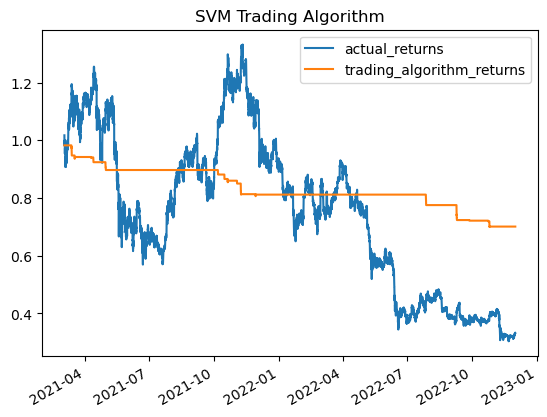

In [36]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "SVM Trading Algorithm")

### Add a Logistic Regression Model

In [37]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [38]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

D:\Anaconda\envs\algotrading\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [39]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [40]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.96      0.94      0.95        54
         0.0       0.99      1.00      1.00      2088
         1.0       1.00      0.50      0.67        18

    accuracy                           0.99      2160
   macro avg       0.99      0.81      0.87      2160
weighted avg       0.99      0.99      0.99      2160



In [41]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [42]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       1.00      0.43      0.60       130
         0.0       0.98      1.00      0.99     14552
         1.0       0.90      0.45      0.60       403

    accuracy                           0.98     15085
   macro avg       0.96      0.63      0.73     15085
weighted avg       0.98      0.98      0.98     15085



In [43]:
# Create a new empty predictions DataFrame using code provided below.
lr_predictions_df = pd.DataFrame(index=X_test.index)
lr_predictions_df["predicted_signal"] = lr_testing_signal_predictions
lr_predictions_df["actual_returns"] = btc_df["actual_returns"]
lr_predictions_df["trading_algorithm_returns"] = lr_predictions_df["actual_returns"] * lr_predictions_df["predicted_signal"]
lr_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-03-03 12:00:00,-1.0,0.017428,-0.017428
2021-03-03 13:00:00,0.0,-0.017296,-0.000000
2021-03-03 14:00:00,0.0,-0.012428,-0.000000
2021-03-03 15:00:00,0.0,-0.002003,-0.000000
2021-03-03 16:00:00,0.0,0.008397,0.000000


<AxesSubplot:title={'center':'Logistic Regression Trading Algorithm'}>

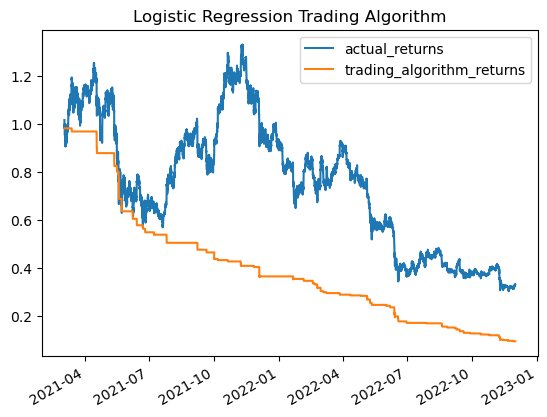

In [44]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "Logistic Regression Trading Algorithm")

## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [45]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       1.00      0.43      0.60       130
         0.0       0.98      1.00      0.99     14552
         1.0       0.90      0.45      0.60       403

    accuracy                           0.98     15085
   macro avg       0.96      0.63      0.73     15085
weighted avg       0.98      0.98      0.98     15085



In [47]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.30      0.37       130
         0.0       0.97      1.00      0.98     14552
         1.0       0.00      0.00      0.00       403

    accuracy                           0.96     15085
   macro avg       0.49      0.43      0.45     15085
weighted avg       0.94      0.96      0.95     15085



## Predicting Signals with Neural Network



In [60]:
#Defining the number of inputs for the model
number_inputs = 20

#Define the number of nodes for the first hidden layer
hidden_nodes_layer1 = 14

#Define the number of nodes for the second hidden layer
hidden_nodes_layer2 = 8

In [61]:
#Initialising the Sequential model
nn_model = Sequential()

In [62]:
# Add the first Dense layer specifying the number of inputs, the number of hidden nodes, and the activation function
nn_model.add(
    Dense(units=hidden_nodes_layer1, input_dim=number_inputs, activation="relu")
)

# Add the second Dense layer specifying the number of hidden nodes and the activation function
nn_model.add(
    Dense(units=hidden_nodes_layer2, activation="relu")
)

# Add the output layer to the model specifying the number of output neurons and activation function
nn_model.add(Dense(units=1, activation="sigmoid"))

In [63]:
# Display the Sequential model summary
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 14)                294       
                                                                 
 dense_4 (Dense)             (None, 8)                 120       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 423
Trainable params: 423
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Compile the Sequential model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [65]:
# Fit the model using 100 epochs and the training data
nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
68/68 [==============================] - 1s 836us/step - loss: 0.2750 - accuracy: 0.9509
Epoch 2/100
68/68 [==============================] - 0s 806us/step - loss: 0.0041 - accuracy: 0.9667
Epoch 3/100
68/68 [==============================] - 0s 851us/step - loss: -0.1586 - accuracy: 0.9667
Epoch 4/100
68/68 [==============================] - 0s 821us/step - loss: -0.3909 - accuracy: 0.9667
Epoch 5/100
68/68 [==============================] - 0s 761us/step - loss: -0.7589 - accuracy: 0.9667
Epoch 6/100
68/68 [==============================] - 0s 791us/step - loss: -1.3859 - accuracy: 0.9667
Epoch 7/100
68/68 [==============================] - 0s 806us/step - loss: -2.3759 - accuracy: 0.9667
Epoch 8/100
68/68 [==============================] - 0s 836us/step - loss: -3.9064 - accuracy: 0.9667
Epoch 9/100
68/68 [==============================] - 0s 866us/step - loss: -5.9908 - accuracy: 0.9667
Epoch 10/100
68/68 [==============================] - 0s 836us/step - loss: -8.7757 

In [66]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)

# Display the evaluation results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

472/472 - 0s - loss: -1.4638e+03 - accuracy: 0.9647 - 365ms/epoch - 773us/step
Loss: -1463.7911376953125, Accuracy: 0.9646669030189514


In [67]:
nn_pred = nn_model.predict(X_test_scaled)
nn_pred

472/472 [==============================] - 0s 586us/step


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [68]:
nn_predictions_df = pd.DataFrame(index=X_test.index)
nn_predictions_df["predicted_signal"] = nn_pred
nn_predictions_df["actual_returns"] = btc_df["actual_returns"]
nn_predictions_df["neural_network_algorithm_returns"] = nn_predictions_df["actual_returns"] * nn_predictions_df["predicted_signal"]

<AxesSubplot:title={'center':'Neural Network Trading Algorithm'}>

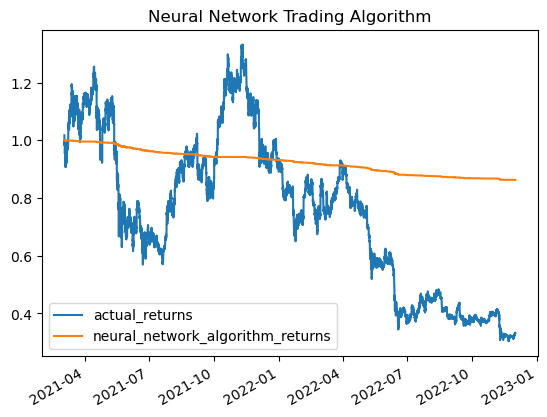

In [70]:
(1 + nn_predictions_df[["actual_returns", "neural_network_algorithm_returns"]]).cumprod().plot(title = "Neural Network Trading Algorithm")